## TODO:
- Implement "harvest rain"
- Check with TL harvest dates
- Implement floraison period


,debourrement,mi-floraison M,mi-floraison CS,veraison,vendanges,deb vendanges,fin vendanges,floraison,nouaison,debut floraison,fin floraison,Debourrement-floraison interval,Floraison-veraison interval,Veraison-Harvest interval,Growing season duration
vintage,,,,,,,,,,,,,,,
1961,1961-03-10,1961-05-29,1961-05-29,1961-08-08,1961-09-23,1961-09-19,1961-09-28,1961-05-29,1961-06-13,1961-05-22,1961-06-05,80,71,46,197
1962,1962-04-18,1962-06-15,1962-06-15,1962-08-18,1962-10-10,1962-10-01,1962-10-20,1962-06-15,1962-06-30,1962-06-08,1962-06-22,58,64,53,175
1963,1963-04-10,1963-06-18,1963-06-18,1963-08-15,1963-10-16,1963-10-10,1963-10-23,1963-06-18,1963-07-03,1963-06-11,1963-06-25,69,58,62,189
1964,1964-04-05,1964-06-14,1964-06-14,1964-08-13,1964-10-01,1964-09-25,1964-10-08,1964-06-14,1964-06-29,1964-06-07,1964-06-21,70,60,49,179
1965,1965-03-31,1965-06-28,1965-06-28,1965-08-15,1965-10-10,1965-10-04,1965-10-16,1965-06-28,1965-07-13,1965-06-21,1965-07-05,89,48,56,193


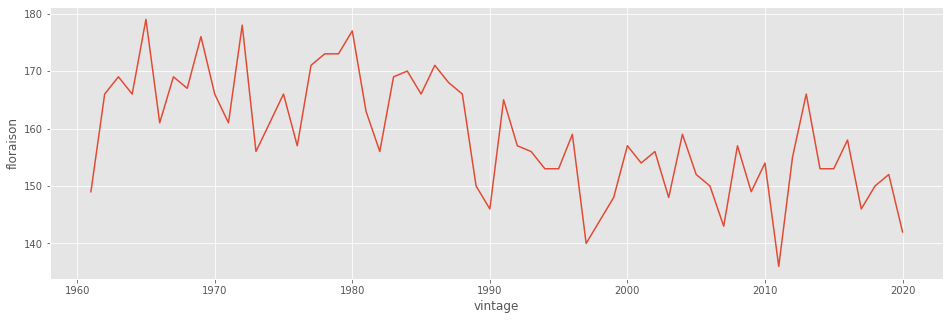

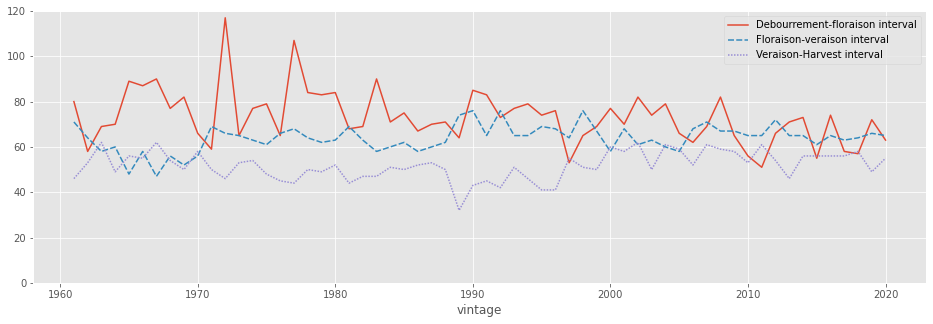

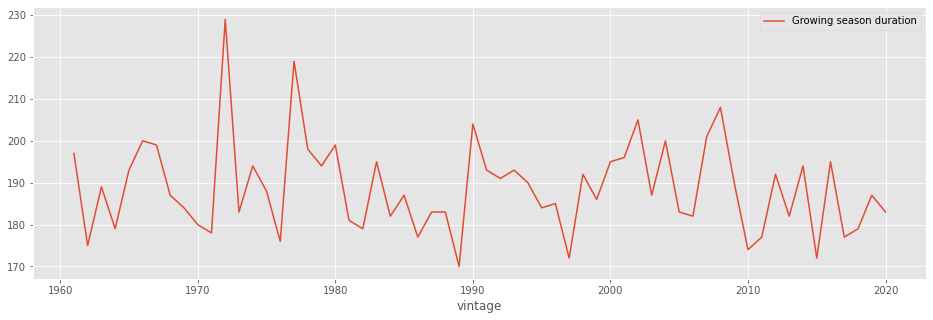

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 5)

pheno = pd.read_excel('data/pheno_latour.xlsx', index_col=0)
pheno['floraison'] = pheno['mi-floraison M']

pheno['vendanges'] = pd.to_datetime(pheno['vendanges'].dt.date)
pheno['veraison'] = pd.to_datetime(pheno['veraison'].dt.date)
pheno['nouaison'] = pheno['floraison'] + datetime.timedelta(days=15)
pheno['debut floraison'] = pheno['floraison'] - datetime.timedelta(days=7)
pheno['fin floraison'] = pheno['floraison'] + datetime.timedelta(days=7)


pheno['Debourrement-floraison interval'] = (pheno['floraison'] - pheno['debourrement']).dt.days
pheno['Floraison-veraison interval'] = (pheno['veraison'] - pheno['floraison']).dt.days
pheno['Veraison-Harvest interval'] = (pheno['vendanges'] - pheno['veraison']).dt.days
pheno['Growing season duration'] = (pheno['vendanges'] - pheno['debourrement']).dt.days

display(pheno.head())

sns.lineplot(data=(pheno['floraison'].dt.dayofyear))
plt.show()

intervalles = pheno[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']]
plt.ylim((0,120))
sns.lineplot(data=intervalles)
plt.show()

sns.lineplot(data=pheno[['Growing season duration']])
plt.show()

In [3]:
weather = pd.read_csv('data/weather_merignac_daily.csv', parse_dates=['Date']).set_index('Date')
weather['Frost'] = (weather['Tn'] < 0).astype(int)
weather['DTR'] = weather['Tx'] - weather['Tn']
weather = weather.drop(['Pr', 'Hail'], axis=1)
#weather['CI'] = (weather['Tn'] < 15).astype(int)
#weather['Huglin'] = ((weather['Tx']-10) + (weather['Tm']-10))/2
weather['Heavy Rain'] = (weather['P'] > 30).astype(int)
weather['Stress'] = 0.5*weather['ETPmon'] - weather['P']
ORIG_WEATHER_FEATURES = list(weather.columns)
weather['Tm-25'] = (weather['Tx']<30).astype(int) * (weather['Tm']>20).astype(int)
weather['GDD10'] = ((weather['Tx']+weather['Tx'])/2 > 10).astype(int) * ((weather['Tx']+weather['Tx'])/2 - 10)

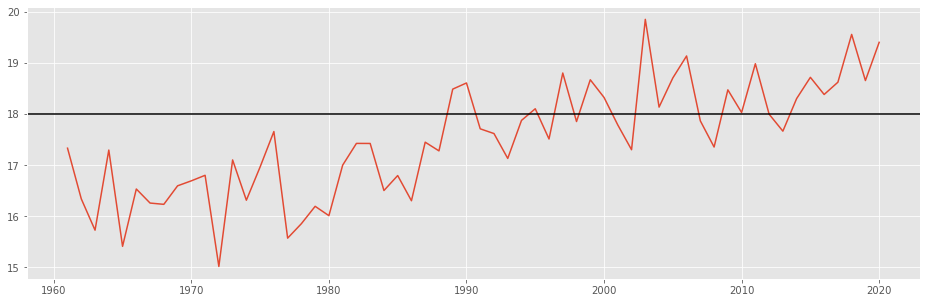

In [4]:
import datetime

vintages = list(pheno.index)

df = pd.DataFrame(index = vintages)
events = ['debourrement', 'floraison', 'veraison', 'vendanges']

# Adding all base features
for feature in ORIG_WEATHER_FEATURES:
    intervals = [[events[i], events[i+1]] for i in range(len(events)-1)]

    subfeatures_list = [feature + ': '+ interval[0] + ' - ' + interval[1] for interval in intervals]
    for subfeature in subfeatures_list:
        df[subfeature] = 0

    for interval in intervals:
        feature_name = feature + ': '+ interval[0] + ' - ' + interval[1]
        for vintage in vintages:
            date_begin, date_end = pheno.loc[vintage, interval[0]], pheno.loc[vintage, interval[1]]
            if feature in ['P', 'Hail', 'ETPmon', 'Wind', 'Frost', 'GDD10', 'Stress', 'Heavy Rain']:
                df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].sum()  
                
                
            #elif feature == 'GDD':
            #    date_debourrement = pheno.loc[vintage, 'debourrement']
            #    df.loc[vintage, feature_name] = weather.loc[date_debourrement:date_end, feature].sum()           
            else:
                df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].mean()
                
df['Growing Season Tm'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = datetime.date(vintage, 4, 1) # Begin on April 1
    date_end = datetime.date(vintage , 9, 30) # End in September
    df.loc[vintage, 'Growing Season Tm'] += weather.loc[date_begin:date_end, 'Tm'].mean()
   


#### Adding other features

# Early frost: from October to November
df['Prev Fall Frost'] = 0
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 9, 1) # Begin on October 1, previous year
    date_end = datetime.date(vintage - 1, 11, 1) # End in December
    df.loc[vintage, 'Prev Fall Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
           
    date_begin = datetime.date(vintage - 1, 11, 1) # Begin on October 1, previous year
    date_end = datetime.date(vintage - 1, 12, 1) # End in December
    df.loc[vintage, 'Prev Fall Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
    
# Early frost: from October to November
df['Winter Frost'] = 0
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 12, 1) # Begin on Dec 1, previous year
    date_end = pheno.loc[vintage, 'debourrement'] - datetime.timedelta(days=15) # End in Feb
    df.loc[vintage, 'Winter Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
           
# Winter Tm
df['Winter Tn'] = 0
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 12, 15) # Begin on October 1, previous year
    date_end = datetime.date(vintage , 3, 1) # End mid March
    df.loc[vintage, 'Winter Tn'] += weather.loc[date_begin:date_end, 'Tn'].mean()

df['Winter Rain'] = 0
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 10, 1) # Begin on October 1, previous year
    date_end = datetime.date(vintage , 3, 1) # End mid March
    df.loc[vintage, 'Winter Rain'] += weather.loc[date_begin:date_end, 'P'].mean()

#df['Debourrement date'] = pheno['debourrement'].dt.dayofyear
#df['Floraison date'] = pheno['floraison'].dt.dayofyear
#df['Veraison date'] = pheno['veraison'].dt.dayofyear
#df['Harvest date'] = pheno['vendanges'].dt.dayofyear

df['Dormancy'] = 0
weather['CD'] = (weather['Tm'] <= 7.2).astype(int)
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 10, 1) # Begin on October 1, previous year
    date_end = datetime.date(vintage , 3, 1) # End mid March
    
    df.loc[vintage, 'Dormancy'] += ((weather.loc[date_begin:date_end, 'CD'] * weather.loc[date_begin:date_end, 'CD'].shift(1) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(2) * weather.loc[date_begin:date_end, 'CD'].shift(3) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(4) * weather.loc[date_begin:date_end, 'CD'].shift(5) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(6) * weather.loc[date_begin:date_end, 'CD'].shift(7) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(8) * weather.loc[date_begin:date_end, 'CD'].shift(9) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(10) * weather.loc[date_begin:date_end, 'CD'].shift(11) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(12) * weather.loc[date_begin:date_end, 'CD'].shift(13)).sum() > 0).astype(int)
    
    
df['Harvest Rain'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'deb vendanges'] - datetime.timedelta(days=7)
    date_end = pheno.loc[vintage, 'fin vendanges'] - datetime.timedelta(days=15)
    df.loc[vintage, 'Harvest Rain'] = weather.loc[date_begin:date_end, 'P'].sum()

# Floraison conditions
df['Floraison Wind'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison Wind'] += ((weather.loc[date_begin:date_end, 'Wind'])).mean()
    
df['Floraison P'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison P'] += (weather.loc[date_begin:date_end, 'P']).sum()
    
    
df['Floraison Heavy Rain'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison Heavy Rain'] += (weather.loc[date_begin:date_end, 'Heavy Rain']).sum()
    
    
df['Floraison Tm'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison Tm'] += (weather.loc[date_begin:date_end, 'Tm']).sum()

#Vend et precip 0
#Temp pas au dessus de 25


df['Floraison Tm-25'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison Tm-25'] += (weather.loc[date_begin:date_end, 'Tm-25']).sum()
    
df['GDD10'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = datetime.date(vintage, 4, 1)
    date_end = pheno.loc[vintage, 'vendanges']
    df.loc[vintage, 'GDD10'] += (weather.loc[date_begin:date_end, 'GDD10']).sum()
    
    
df['P: veraison - vendanges 2'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'veraison'] + datetime.timedelta(days=14)
    date_end = pheno.loc[vintage, 'vendanges']
    df.loc[vintage, 'P: veraison - vendanges 2'] += (weather.loc[date_begin:date_end, 'P']).sum()
    
#df['Enough GDD10'] = (df['GDD10'] > 2530).astype(int)
df = df.drop(['Frost: floraison - veraison', 'Frost: veraison - vendanges'], axis=1)

plt.plot(df['Growing Season Tm'])
plt.axhline(18, color='black')
plt.show()

In [5]:
df[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']] = pheno[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']]
prices = pd.read_excel('data/generated_average_prices.xlsx', index_col=0)
display(prices.head())


df['Stress'] = 0.5*(df['ETPmon: floraison - veraison'] + df['ETPmon: veraison - vendanges']) - (df['P: floraison - veraison'] + df['P: veraison - vendanges'])
df['Stress'] = (df['Stress'] > -150).astype(int) * df['Stress']
df = df.drop(['ETPmon: debourrement - floraison', 'ETPmon: floraison - veraison', 'ETPmon: veraison - vendanges'], axis=1)
df = df.drop(['Stress: debourrement - floraison', 'Stress: floraison - veraison', 'Stress: veraison - vendanges'], axis=1)

#df['Huglin Growing Season'] = df['Huglin: debourrement - floraison'] + df['Huglin: floraison - veraison'] + df['Huglin: veraison - vendanges']

df['Floraison P'] = (df['Floraison P'] > 30).astype(int) * df['Floraison P']

,Price
Vintage,
1950,479.821429
1951,701.875000
1952,243.000000
1953,679.178571
1954,721.000000


## Important

Only goal of unskewing prices is to put them closer to the 0-1 range, but any transformation that leaves their order untouched does not change the predictive power. HOWEVER, it probably helps training the reg model.

               skew  kurtosis
Log price  0.973248  1.667806


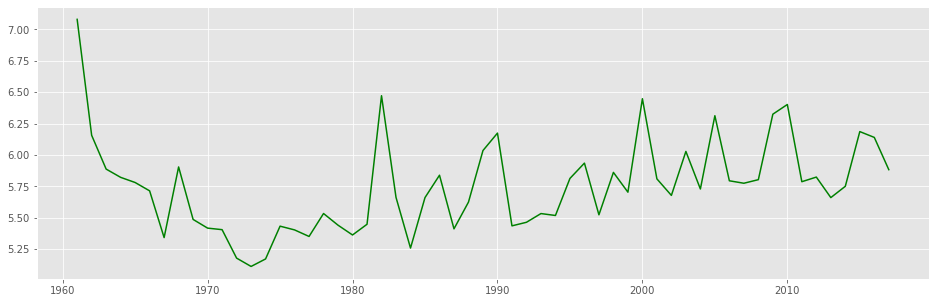

In [6]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew



######### Yeo Johnson transofrmation


price = prices['Price'].loc[1961:]
price = np.log(price)

#pt = PowerTransformer()
#price = pt.fit_transform(np.log(prices['Price'].loc[1961:]).values.reshape(-1,1))/2

#print(df.agg(['skew', 'kurtosis']).T)


plt.plot(price, color='green')
df = df.loc[1961:2017]

df['Log price'] = price
print(df[['Log price']].agg(['skew', 'kurtosis']).T)

df.to_excel('data/generated_daily_features.xlsx')

['Log price', 'Stress', 'Sun: veraison - vendanges', 'P: veraison - vendanges', 'P: veraison - vendanges 2', 'Tx: floraison - veraison', 'Growing Season Tm', 'Veraison-Harvest interval', 'DTR: floraison - veraison', 'Tm: floraison - veraison']
['Log price', 'Tn: debourrement - floraison', 'DTR: veraison - vendanges', 'P: veraison - vendanges', 'Heavy Rain: debourrement - floraison', 'Stress', 'Winter Frost', 'GDD10', 'Tm: debourrement - floraison', 'P: veraison - vendanges 2']


Log price                               1.000000
Tn: debourrement - floraison            0.659094
DTR: veraison - vendanges               0.607287
P: veraison - vendanges                 0.599572
Heavy Rain: debourrement - floraison    0.574671
Stress                                  0.565240
Winter Frost                            0.534343
GDD10                                   0.526496
Tm: debourrement - floraison            0.468215
P: veraison - vendanges 2               0.446975
Name: Log price, dtype: float64

Log price                               1.000000
DTR: veraison - vendanges               0.803432
Stress                                  0.756538
Sun: veraison - vendanges               0.747568
P: veraison - vendanges                 0.737499
P: veraison - vendanges 2               0.685498
Floraison P                             0.554130
Heavy Rain: debourrement - floraison    0.553108
GDD10                                   0.537992
Floraison Tm                            0.516777
Name: Log price, dtype: float64

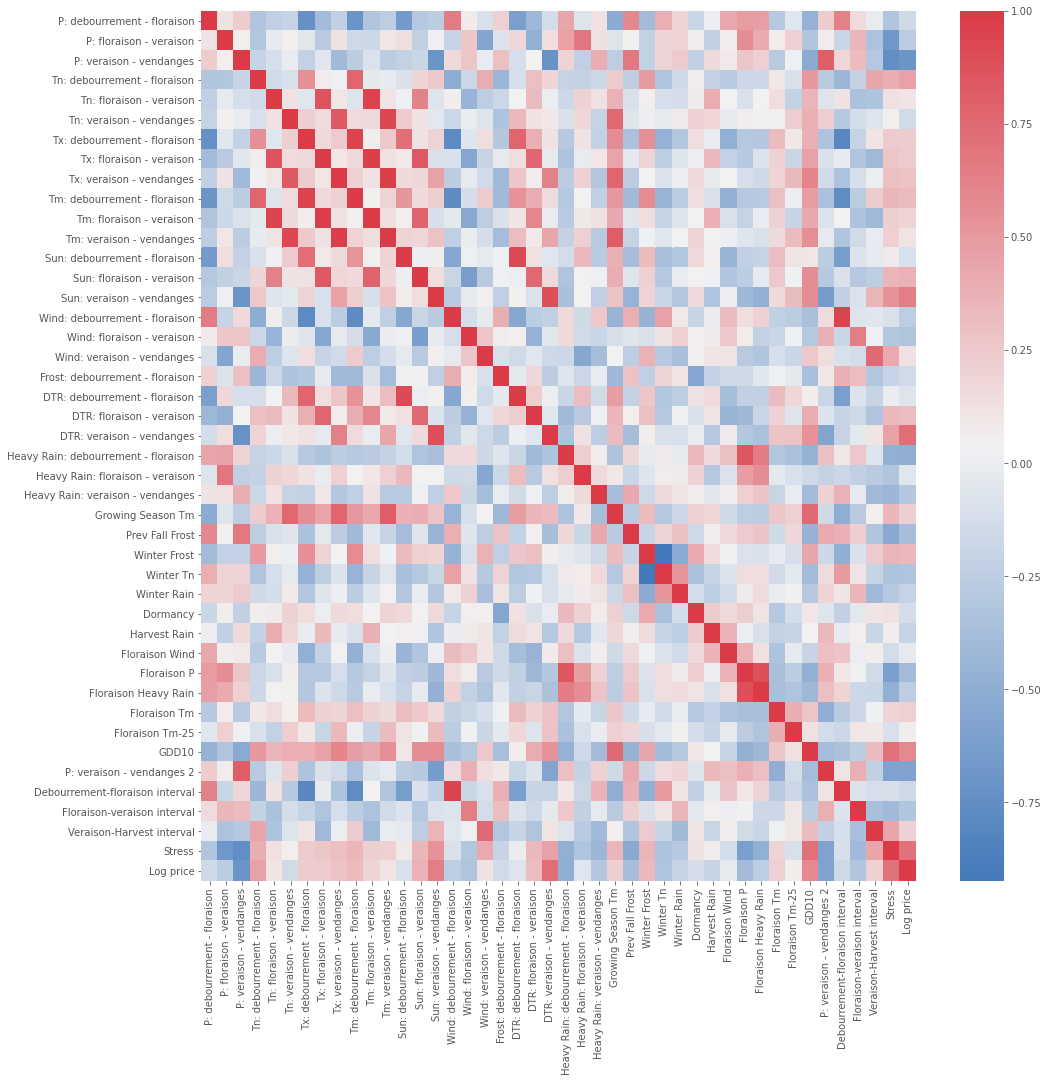

In [7]:
print(list(df.loc[1983:1993, :].corr()['Log price'].abs().nlargest(10).index))
print(list(df.loc[1994:2004, :].corr()['Log price'].abs().nlargest(10).index))

display(df.loc[1994:2004, :].corr()['Log price'].abs().nlargest(10))
display(df.loc[2005:, :].corr()['Log price'].abs().nlargest(10))

plt.figure(figsize=(16,16))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(df.loc[1994:, :].corr(), cmap=cmap)
plt.show()

### Show correlations and pvals

['Sun: veraison - vendanges', 'P: veraison - vendanges', 'Stress', 'P: veraison - vendanges 2', 'DTR: debourrement - floraison', 'Winter Frost', 'Growing Season Tm', 'Tm: floraison - veraison', 'DTR: veraison - vendanges', 'Tx: veraison - vendanges']


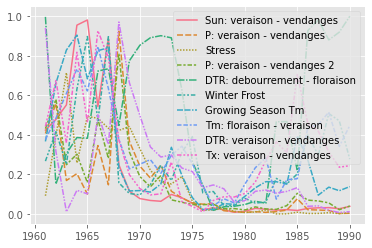

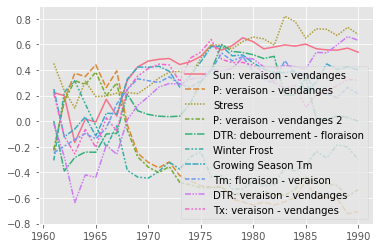

In [122]:
from scipy.stats import pearsonr
from sklearn.ensemble import ExtraTreesRegressor

features = list(df.columns)
features.remove('Log price')
periods = [year for year in range(1961, 1991)]
correlations = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)
pvals = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)
importances = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)

for year in range(1961, 1991):
    for feature in features:
        X_train, y_train = df.loc[year:year+14, feature], df.loc[year:year+14, 'Log price']
        corr = pearsonr(X_train, y_train)
        
        correlations.loc[year, feature] = corr[0]
        pvals.loc[year, feature] = corr[1]
        
    X_train, y_train = df.loc[year:year+14, features], df.loc[year:year+14, 'Log price']
    model = ExtraTreesRegressor()
    model.fit(X_train.values, y_train.values)
    #print(model.feature_importances_)
    importances.loc[year, :] = model.feature_importances_
        
        
pvals_copy = pvals.loc[1979:1979, :].T
pvals_copy['mean'] = pvals_copy.mean(axis=1)
smallest_p_vals = list(pvals_copy['mean'].nsmallest(10).index)
print(smallest_p_vals)


sns.lineplot(data=pvals[smallest_p_vals])
plt.show()

sns.lineplot(data=correlations[smallest_p_vals])
plt.show()

#importances = importances.loc[1970:, :].T
#importances['mean'] = importances.mean(axis=1)
#largest_importances = list(importances['mean'].nlargest(5).index)
#print(largest_importances)

Sun: veraison - vendanges        0.587096
Stress                           0.580548
P: veraison - vendanges          0.568121
DTR: debourrement - floraison    0.542677
P: veraison - vendanges 2        0.532604
Growing Season Tm                0.515717
Tm: floraison - veraison         0.472898
Winter Frost                     0.464288
Tx: veraison - vendanges         0.428682
Tx: floraison - veraison         0.402738
DTR: veraison - vendanges        0.387451
Floraison Heavy Rain             0.378440
Tm: veraison - vendanges         0.377510
Sun: debourrement - floraison    0.370140
Veraison-Harvest interval        0.342425
Name: mean, dtype: float64


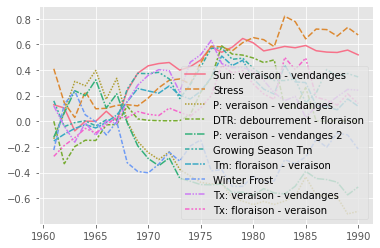

P: veraison - vendanges             0.623682
Sun: veraison - vendanges           0.611698
Stress                              0.604872
P: veraison - vendanges 2           0.562657
DTR: debourrement - floraison       0.511269
Winter Frost                        0.481680
Growing Season Tm                   0.463088
DTR: veraison - vendanges           0.426394
Tm: floraison - veraison            0.413823
Tx: veraison - vendanges            0.409190
Tx: floraison - veraison            0.354677
Heavy Rain: veraison - vendanges    0.353392
Sun: debourrement - floraison       0.345267
Harvest Rain                        0.344430
Tm: veraison - vendanges            0.339730
Name: mean, dtype: float64


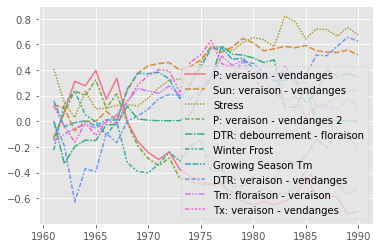

In [123]:
from sklearn.linear_model import LinearRegression
%matplotlib inline
product = correlations * (1-pvals)
product_copy = product.loc[1977:1979, :].T

#product_copy2 = product_copy.copy()
#for feature in list(product_copy.index):
#    linreg = LinearRegression()
#    linreg.fit(np.array(list(product_copy.T.index)).reshape(-1,1), product_copy.T[feature].values.reshape(-1,1))
#    product_copy2.loc[feature, 'pred'] = linreg.predict(np.array(1983).reshape(1,-1)).ravel()[0] 
        
product_copy['mean'] = product_copy.mean(axis=1)
print(abs(product_copy['mean']).nlargest(15))#

a = (list(abs(product_copy['mean']).nlargest(10).index))
sns.lineplot(data=product[a])
plt.show()

product_copy = product.loc[1978:1980, :].T
#product_copy2 = product_copy.copy()
#for feature in list(product_copy.index):
#    linreg = LinearRegression()
#    linreg.fit(np.array(list(product_copy.T.index)).reshape(-1,1), product_copy.T[feature].values.reshape(-1,1))
#    product_copy2.loc[feature, 'pred'] = linreg.predict(np.array(1983).reshape(1,-1)).ravel()[0] 
        
product_copy['mean'] = product_copy.mean(axis=1)
print(abs(product_copy['mean']).nlargest(15))#

a = (list(abs(product_copy['mean']).nlargest(10).index))
sns.lineplot(data=product[a])
plt.show()

C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is co

Spearman top features:  ['Stress', 'Sun: veraison - vendanges', 'Tm: floraison - veraison', 'DTR: veraison - vendanges', 'P: veraison - vendanges', 'Tx: floraison - veraison', 'P: veraison - vendanges 2', 'Veraison-Harvest interval', 'Wind: veraison - vendanges', 'Tx: veraison - vendanges']


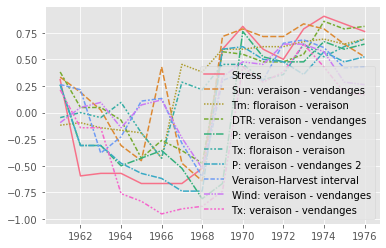

Spearman top features:  ['Sun: veraison - vendanges', 'Stress', 'Growing Season Tm', 'P: veraison - vendanges 2', 'Tn: floraison - veraison', 'P: veraison - vendanges', 'Veraison-Harvest interval', 'Wind: veraison - vendanges', 'DTR: veraison - vendanges', 'Tm: floraison - veraison', 'Tx: debourrement - floraison', 'GDD10', 'Tm: debourrement - floraison', 'Harvest Rain', 'Wind: debourrement - floraison', 'Floraison Tm', 'Tn: debourrement - floraison', 'Debourrement-floraison interval', 'Wind: floraison - veraison', 'Tx: floraison - veraison', 'Heavy Rain: floraison - veraison', 'P: debourrement - floraison', 'Floraison Tm-25', 'DTR: debourrement - floraison', 'Prev Fall Frost', 'Heavy Rain: veraison - vendanges', 'Floraison Wind', 'Tn: veraison - vendanges', 'Dormancy', 'Winter Frost']


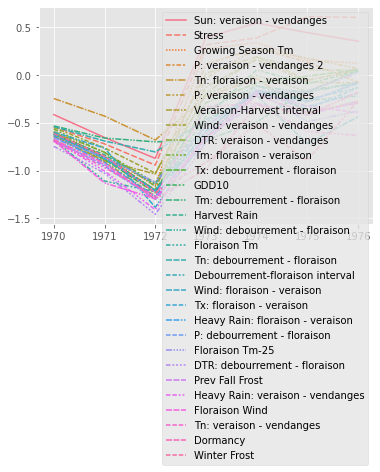

In [114]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, pearsonr

features = list(df.columns)
features.remove('Log price')
periods = [year for year in range(1961, 1977)]
rsq = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)
spe = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)

for year in range(1961, 1977):
    for feature in features:
        X_train, y_train = df.loc[year:year+9, feature], df.loc[year:year+9, 'Log price']
        X_test, y_test = df.loc[year+10:year+17, feature], df.loc[year+10:year+17, 'Log price']

        
        mod = LinearRegression()
        mod.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))
        pred = mod.predict(X_test.values.reshape(-1,1))
        spe.loc[year, feature] = spearmanr(y_test, pred).correlation

        spe.loc[year, feature] = spearmanr(y_test, pred).correlation
        rsq.loc[year, feature] = mod.score(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1))
        #print(spearmanr(y_test, pred).correlation)
        

spe_copy = spe.loc[1970:, :].T
spe_copy['mean'] = spe_copy.mean(axis=1)
largest_p_vals = list(spe_copy['mean'].nlargest(10).index)
print('Spearman top features: ',largest_p_vals)

sns.lineplot(data = spe[largest_p_vals])
plt.show()

rsq_copy = rsq.loc[1970:, :].T
rsq_copy['mean'] = rsq_copy.mean(axis=1)
largest_p_vals = list(rsq_copy['mean'].nlargest(30).index)
print('Spearman top features: ',largest_p_vals)

sns.lineplot(data = rsq.loc[1970:, largest_p_vals])
plt.show()

In [69]:
#sns.regplot(x = df['Floraison Tm Offset'], y = df['Log price'])
#plt.show()

#features = list(df.columns)
#features.remove('Log price')
#for orig_feature in ORIG_WEATHER_FEATURES:
#    print(orig_feature)
#    to_plot = [feature for feature in features if orig_feature+':' in feature]
#    fig, axes = plt.subplots(1, len(to_plot)+1)
#    
#    for i in range(len(to_plot)):
#        sns.regplot(ax = axes[i], x = df[to_plot[i]], y = df['Log price'])
#    plt.show()


In [115]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_selection import SelectFromModel

df_train=df.loc[1980:1993]
X_train = df_train.drop('Log price', axis=1).reset_index().rename(columns={'index':'vintage'})
y_train = df_train[['Log price']]
df_test=df.loc[2000:2017]
X_test = df_test.drop('Log price', axis=1).reset_index().rename(columns={'index':'vintage'})
y_test = df_test[['Log price']]

linreg = LinearRegression()
#forest = RandomForestRegressor(n_estimators=10, max_depth=10)
tree = RandomForestRegressor(n_estimators=30, max_depth=4)
rfe = RFE(linreg, n_features_to_select=10)
sel = SelectFromModel(estimator=LinearRegression())

rfe.fit(X_train,y_train.values.ravel())
sel.fit(X_train,y_train.values.ravel())

print(rfe.score(X_test,y_test))
supp = rfe.support_
supp2 = sel.get_support()#print(export_text(rfe.estimator_))

sel_features = []
for i in range(len(list(X_train.columns))):
    if supp[i]:
        sel_features.append(list(X_train.columns)[i])
print(sel_features)

sel_features = []
for i in range(len(list(X_train.columns))):
    if supp2[i]:
        sel_features.append(list(X_train.columns)[i])
print(sel_features)

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
sfs1 = sfs(linreg,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='r2', #'r2'
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train.values, y_train.values.reshape(-1,1))

feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

sel_features = []
for i in range(len(list(X_train.columns))):
    if i in feat_cols:
        sel_features.append(list(X_train.columns)[i])
print(sel_features)


X_train = X_train[sel_features]
X_test = X_test[sel_features]

linreg = LinearRegression()
linreg.fit(X_train, y_train.values.reshape(-1,1))
pred = linreg.predict(X_test)
print('Spearman: ', spearmanr(y_test, pred).correlation)

-2.3258358329899904
['P: debourrement - floraison', 'P: veraison - vendanges', 'Sun: debourrement - floraison', 'Sun: floraison - veraison', 'Wind: veraison - vendanges', 'Prev Fall Frost', 'Harvest Rain', 'Floraison P', 'Floraison Tm-25', 'Veraison-Harvest interval']
['P: debourrement - floraison', 'P: veraison - vendanges', 'Sun: debourrement - floraison', 'Sun: floraison - veraison', 'Wind: floraison - veraison', 'Prev Fall Frost', 'Winter Frost', 'Harvest Rain', 'Floraison P', 'Floraison Tm-25', 'P: veraison - vendanges 2', 'Debourrement-floraison interval', 'Veraison-Harvest interval', 'Stress']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    0.1s finished

[2021-06-21 11:54:21] Features: 1/5 -- score: -0.7643688797072494[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    0.1s finished

[2021-06-21 11:54:21] Features: 2/5 -- score: -0.4429492273537159[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.1s finished

[2021-06-21 11:54:21] Features: 3/5 -- score: -0.4019882124538194[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[8, 9, 14, 24, 37]
['Tx: floraison - veraison', 'Tx: veraison - vendanges', 'Sun: floraison - veraison', 'Heavy Rain: floraison - veraison', 'Floraison Tm-25']
Spearman:  0.45717234262125905


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished

[2021-06-21 11:54:22] Features: 5/5 -- score: -1.1958437576217937

#### GOOD_FEATURES = ['Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']: Spearman out-sample of 0.70, BEST TO DATE

In [30]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, Lasso, LinearRegression


GOOD_FEATURES = ['Stress', 'P: veraison - vendanges']


#X['Sq Tn: debourrement - floraison'] = X['Tn: debourrement - floraison']**2
df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)[GOOD_FEATURES].reset_index(drop=True)
y = df[['Log price']]
FIRST = 1961
LAST = 2018
WIDTH = 15

def model_tester(X, y, fixed_1994):
    coefficients = pd.DataFrame(0, index=range(FIRST,LAST-WIDTH-1), columns = ['const']+X.columns.to_list())
    r2_scores = []
    predictions = pd.DataFrame(index=range(FIRST+WIDTH+1,LAST), columns=['Log Price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
    for year in coefficients.index:
        oldest_vintage = year
        newest_vintage = year + WIDTH

        y_train = y.loc[oldest_vintage:newest_vintage - 2, 'Log price']
        #X_train = sm.add_constant(X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:])
        X_train = X.loc[oldest_vintage-FIRST:newest_vintage-FIRST - 2,:]
        
        #mod = sm.OLS(y_train.values.reshape(-1,1), X_train)
        #res = mod.fit()
        #coefs = pd.Series(res.params)
        #mod = Lasso(alpha=0.005)
        mod = LinearRegression()
        mod.fit(X_train, y_train.values)
        coefs = mod.coef_
        coefficients.loc[year, X_train.columns] = coefs
        coefficients.loc[year, 'const'] = mod.intercept_
        
        r2_scores.append(r2_score(mod.predict(X_train),y_train))
        spearman_scores.append(spearmanr(mod.predict(X_train),y_train)[0])
        
        
        X_test = X.loc[newest_vintage-FIRST+1:newest_vintage-FIRST+1,:]
        #ones = pd.DataFrame(np.ones(1), index=[newest_vintage-FIRST+1], columns=['const'])
        #X_test = pd.concat((ones, X_test), axis=1)
        
        if fixed_1994:
            if year==1994-WIDTH-1:
                mod_base = mod
                
            if year >=1994-WIDTH-1:
                print(year+WIDTH+1, ': using 1993 model.')
                predictions.loc[newest_vintage+1] = mod_base.predict(X_test.values)[0]

    
            else:
                predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]

        else:
            predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]
    
    return coefficients, r2_scores, spearman_scores, predictions

coefficients, r2_scores, spearman_scores, predictions = model_tester(X, y, fixed_1994 = False)

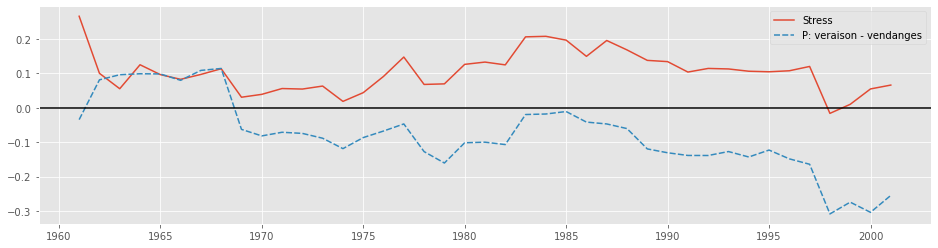

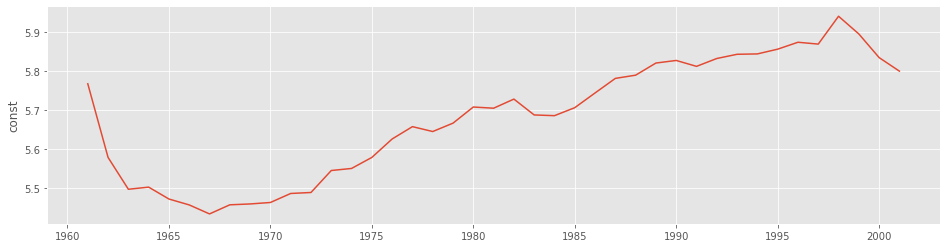

<Figure size 1152x288 with 0 Axes>

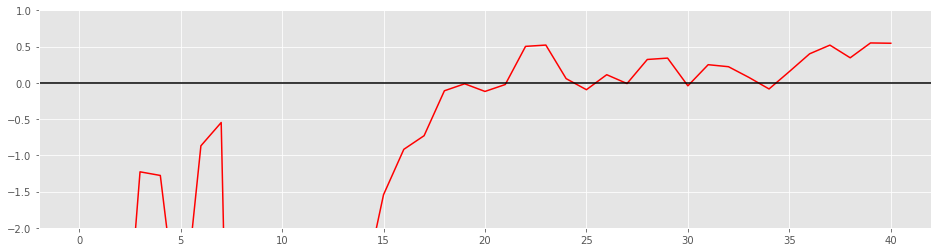

Average in-sample R2 score over the whole period:  -1.5317272576573102


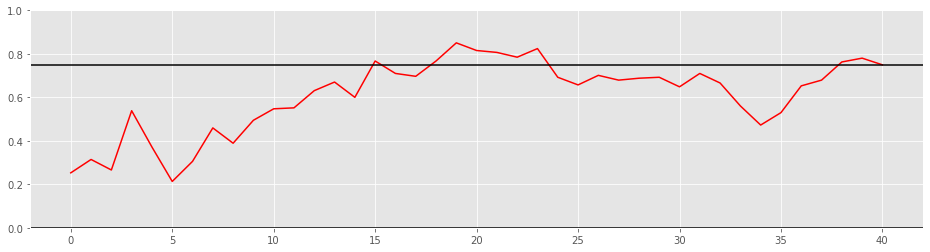

Average in-sample Spearman R over the whole period:  0.6084695792012865


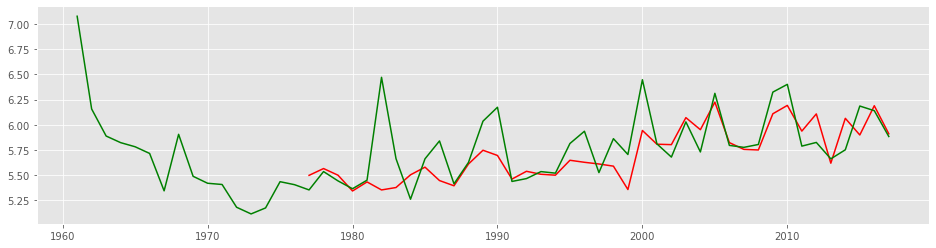

Average out-sample Spearman R over the whole period:  0.636062717770035
Average out-sample Spearman R over the target period:  0.64
MAE over the target period:  0.16112828749045904
Average out-sample R2 over the target period:  0.3564107454076261


In [31]:
plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.iloc[:,1:6]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.iloc[:,0])
plt.show()

plt.figure(figsize=(16,4))
#sns.lineplot(data=coefficients.T.iloc[:,6:]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=r2_scores, color='red').axhline(0., color='black')
plt.ylim((-2,1))
plt.plot(0)
plt.savefig('views/In-sample_R2_simple_regression.png')
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

plt.figure(figsize=(16,4))
sns.lineplot(data=spearman_scores, color='red').axhline(0., color='black')
plt.ylim((0,1))
plt.axhline(0.75, color='black')
plt.savefig('views/In-sample_Spearman_R_simple_regression.png')
plt.show()
print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))

plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')

plt.savefig('views/Spearman_R_simple_regression.png')
plt.show()

def r_squared(x, y):
    return 1 - np.sum(np.square(x - y))/np.sum(np.square(x - np.mean(x)))


print('Average out-sample Spearman R over the whole period: ',spearmanr(predictions.loc[FIRST+WIDTH+1:LAST], y.loc[FIRST+WIDTH+1:LAST])[0])
print('Average out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:LAST], y.loc[1994:LAST])[0])
print('MAE over the target period: ',np.mean(np.abs(predictions.loc[1994:LAST].values- y.loc[1994:LAST].values)))

print('Average out-sample R2 over the target period: ',r_squared(y.loc[1994:LAST].values, predictions.loc[1994:LAST].values))


In [57]:
residual = df.loc[FIRST+WIDTH+1:LAST, 'Log price'] - predictions.loc[FIRST+WIDTH+1:LAST, 'Log Price']
sns.jointplot(x = df.loc[FIRST+WIDTH+1:LAST,'Winter Tx'], y = residual)
plt.show()

KeyError: 'Winter Tx'

# Tree

Spearman: 0.47999191332505026


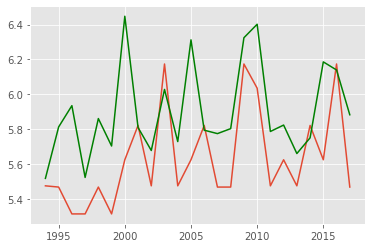

In [79]:
tree_features = ['Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)
X = X[tree_features]

X_train, X_test = X.loc[1961:1993], X.loc[1994:2017]
y_train, y_test = y.loc[1961:1993], y.loc[1994:2017]

dtree = DecisionTreeRegressor(max_depth=5)
dtree.fit(X_train,y_train.values.ravel())

predictions = dtree.predict(X_test)
plt.plot(range(1994, 2018),predictions)
plt.plot(y_test, color='green')
print('Spearman:', spearmanr(predictions, y_test).correlation)

from sklearn import tree

#tree.plot_tree(dtree)

In [80]:
FIRST, LAST = 1961, 2017
window_width = 32

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)[GOOD_FEATURES]
y = df[['Log price']]

def model_tester(X, y):
    r2_scores = []
    predictions = pd.DataFrame(index=range(FIRST + window_width +1,LAST +1), columns=['Log price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
    for year in range(FIRST, LAST - (window_width+1)):
        oldest_vintage = year
        newest_vintage = year + window_width

        y_train = y.loc[oldest_vintage:newest_vintage, 'Log price']
        X_train = X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:]
        
        mod = DecisionTreeRegressor(max_depth=3)
        mod.fit(X_train, y_train.values.ravel())
        
        r2_scores.append(r2_score(mod.predict(X_train),y_train))
        spearman_scores.append(spearmanr(mod.predict(X_train),y_train)[0])
        
        
        X_test = X.loc[newest_vintage-FIRST+1:newest_vintage-FIRST+1,:]        
        predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]
    
    return r2_scores, spearman_scores, predictions

r2_scores, spearman_scores, predictions = model_tester(X, y)

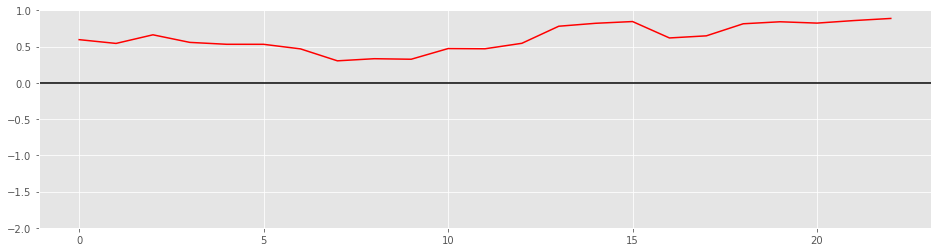

Average in-sample R2 score over the whole period:  0.6212244532251371


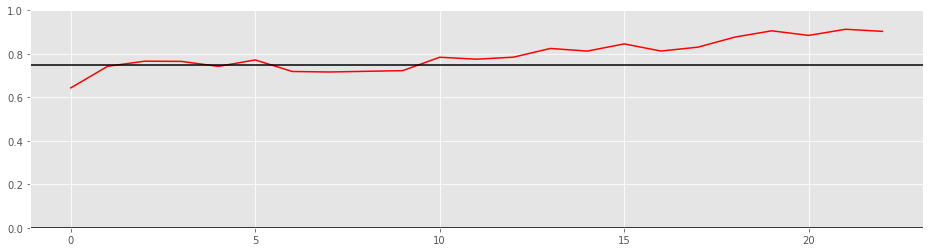

Average in-sample Spearman R over the whole period:  0.7941599346674536


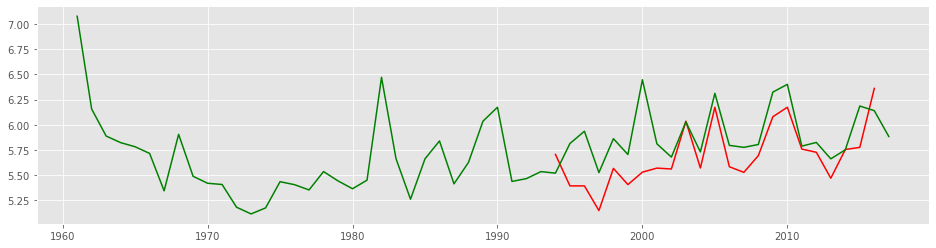

Average out-sample Spearman R over the target period:  0.5090190419788589


In [81]:
plt.figure(figsize=(16,4))
sns.lineplot(data=r2_scores, color='red').axhline(0., color='black')
plt.ylim((-2,1))
plt.plot(0)
plt.savefig('views/In-sample_R2_simple_regression.png')
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

plt.figure(figsize=(16,4))
sns.lineplot(data=spearman_scores, color='red').axhline(0., color='black')
plt.ylim((0,1))
plt.axhline(0.75, color='black')
plt.savefig('views/In-sample_Spearman_R_simple_regression.png')
plt.show()
print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))


plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')

plt.savefig('views/Spearman_R_simple_regression.png')
plt.show()
print('Average out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:2016], y.loc[1994:2016])[0])

# Appendix: PCA

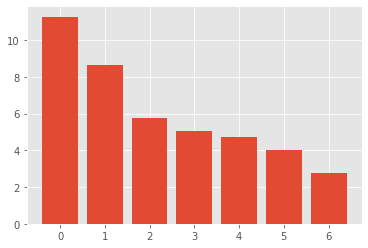

,0,1,2,3,4,5,6
1980,-4.354726,1.794528,0.970380,0.180457,1.694633,-0.256372,-1.641731
1981,0.832289,-2.561261,-1.263189,1.072136,0.367313,-0.680976,-1.267017
1982,2.985240,-0.121465,-2.080035,-0.772342,-1.123292,3.158297,2.591032
1983,1.130416,2.353051,2.173226,-0.231008,-3.864273,-0.755364,-1.200368
1984,-1.813309,-1.169158,-1.870055,-2.802077,1.346254,-1.121126,-0.302894


In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

X = df.drop('Log price', axis=1).loc[1961:1994]

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1980:,:]


pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)
display(X2.head())

In [83]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt


def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,2]
    n = coeff.shape[0]
    #plt.scatter(xs ,ys) #without scaling
    for i in range(len(labels)):
        plt.arrow(0, 0, coeff[0,i], coeff[1,i],color = 'r',alpha = 0.5)
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, labels[i], color = 'g', ha = 'center', va = 'center')

            
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')

coef = pca.components_

ax.scatter(coef[0,:] , coef[1, :] , coef[2, :])

for i in range(len(X.columns)):
    ax.text(coef[0,i]+np.mean(coef[0,:])/1000,coef[1,i]+np.mean(coef[1,:])/1000 ,coef[2,i]+np.mean(coef[2,:])/1000, list(X.columns)[i], zdir=None)

# 